In [1]:
#import dataset

from google.colab import drive
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# 1. Access to Google Drive
drive.mount('/content/drive')
caminho_arquivo = '/content/drive/MyDrive/caseshape/O_G_Equipment_Data.xlsx' # caminho do arquivo no drive

# 3. Load file in pandas and spark
base_pd = pd.read_excel(caminho_arquivo)
base = spark.createDataFrame(base_pd)

Mounted at /content/drive


In [43]:
#import the libraries

# view
import matplotlib.pyplot as plt
import seaborn as sns

# analyses
import pandas as pd
import numpy as np
from scipy import stats
import ast
import string
import warnings
import os

# Spark
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import lit, col
from pyspark.sql.types import StringType

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_recall_fscore_support
)
from xgboost import XGBClassifier
import shap


In [4]:
base.show()


+-----+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|Cycle|Preset_1|Preset_2|       Temperature|          Pressure|        VibrationX|        VibrationY|        VibrationZ|         Frequency| Fail|
+-----+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|    1|       3|       6| 44.23518586415284| 47.65725354833926| 46.44176923068589| 64.82032657891138| 66.45451956495226| 44.48324980824037|false|
|    2|       2|       4|60.807234448796294| 63.17207576842222| 62.00595106708013| 80.71443106372683|  81.2464046543589|60.228714793422036|false|
|    3|       2|       1| 79.02753565280922| 83.03218967065293| 82.64210959422543|  98.2543855725768| 98.78519593981386| 80.99347914594966|false|
|    4|       2|       3| 79.71624156697328| 100.5086344886615|122.36232148005857|121.36342870189367|118.65253755569158| 80.

In [5]:
base.count()

800




Df description of the features:

1.	Cycle: Sequential identifier of measurement cycles.

2.	Preset_1 & Preset_2: Variables that control a specific operating point of the machine.

3.	Temperature: Temperature recorded in the equipment.

4.	Vibrations (X, Y & Z): Vibrations along the machine's axes.

5.	Frequency: Operating frequency of the machine.

6.	Fail: Variable indicating whether the machine is in a failure state at the given timestamp.


**Dataset cleaning and exploration**

In [5]:
base.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in base.columns
]).show()

# no null values

+-----+--------+--------+-----------+--------+----------+----------+----------+---------+----+
|Cycle|Preset_1|Preset_2|Temperature|Pressure|VibrationX|VibrationY|VibrationZ|Frequency|Fail|
+-----+--------+--------+-----------+--------+----------+----------+----------+---------+----+
|    0|       0|       0|          0|       0|         0|         0|         0|        0|   0|
+-----+--------+--------+-----------+--------+----------+----------+----------+---------+----+



In [6]:
# dataset features

num_cols = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]


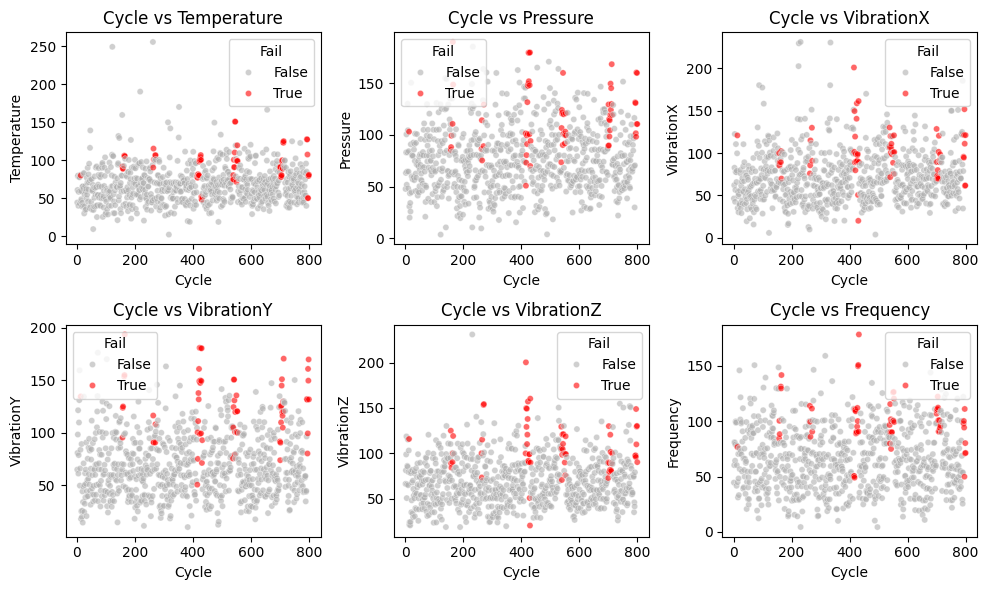

In [7]:
# this plot shows how each variable evolves over the equipment’s operating cycles


fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.ravel()

for ax, col in zip(axes, num_cols):
    sns.scatterplot(
        data=base_pd,
        x="Cycle",
        y=col,
        hue="Fail",
        palette=["#b0b0b0", "red"],  # in red the fail point
        s=20,
        alpha=0.6,
        ax=ax,
    )
    ax.set_title(f"Cycle vs {col}")

plt.tight_layout()
plt.show()

# some outliers were identified, representing extreme measurements where the equipment still remained in operation

In [8]:
# check the outliers

base.select(
    *[F.mean(c).alias(f"{c}_mean") for c in num_cols],
    *[F.stddev(c).alias(f"{c}_std") for c in num_cols],
).show()

for c in num_cols:
    q = base.approxQuantile(c, [0.01, 0.5, 0.99], 0.001)
    print(f"{c}: q01={q[0]:.2f}, q50={q[1]:.2f}, q99={q[2]:.2f}")


# This loop estimates the 1st, 50th, and 99th percentiles (q01, q50, q99) for each numerical variable using Spark’s approxQuantile method.
#These percentiles help identify the typical value distribution and detect extreme values or potential outliers.

+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
| Temperature_mean|   Pressure_mean|  VibrationX_mean|  VibrationY_mean|  VibrationZ_mean|   Frequency_mean|  Temperature_std|      Pressure_std|    VibrationX_std|   VibrationY_std|    VibrationZ_std|    Frequency_std|
+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|69.26349356745824|78.9979447766558|73.86027479321497|72.78687816363349|71.86621064492759|68.22344937760928|25.53625169684274|32.501833621210714|31.229631205254286|32.73974524830075|27.844616396373894|29.13870236867777|
+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+------------

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

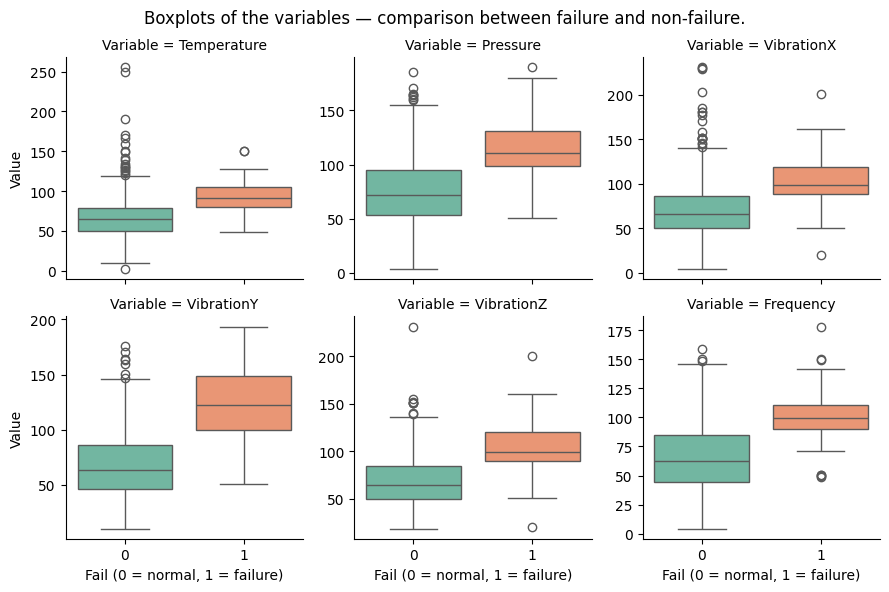

In [14]:
# fail to category int
base_pd["Fail"] = base_pd["Fail"].astype(int)

# transform data into long format
df_long = base_pd.melt(
    id_vars="Fail",
    value_vars=num_cols,
    var_name="Variable",
    value_name="Value"
)


# plot with FacetGrid
g = sns.FacetGrid(df_long, col="Variable", col_wrap=3, height=3, sharey=False)
g.map_dataframe(sns.boxplot, x="Fail", y="Value", palette="Set2")

g.set_axis_labels("Fail (0 = normal, 1 = failure)", "Value")
g.fig.suptitle("Boxplots of the variables — comparison between failure and non-failure.", fontsize=12)
plt.subplots_adjust(top=0.90)

plt.show()


**BOXPLOT EXPLANATION**


The boxplots illustrate the distribution of each sensor variable when the equipment is operating normally (Fail = 0) versus during pre-failure or failure conditions (Fail = 1). Clear distributional shifts are observed across all variables, indicating measurable degradation patterns associated with failure events.

Temperature and Pressure exhibit an upward shift in their median and interquartile range under failure conditions, suggesting sustained thermal and hydraulic stress.

In contrast, all three vibration channels (VibrationX, VibrationY, VibrationZ) show pronounced increases in both central tendency and variability, reflecting growing mechanical instability and higher oscillatory energy as the system deteriorates. Frequency also shifts upward, indicating changes in rotational dynamics or load conditions near failure.

These patterns confirm that the system expresses clear signatures of degradation across multiple physical domains—thermal, hydraulic, mechanical, and rotational—and support the use of these variables as reliable predictors in the failure-forecasting model

To investigate pre-failure patterns, I analyzed the sensor behavior in the cycles immediately preceding each failure event. For every failure, I extracted the sensor values at t-2, t-5, and t-8 cycles before the event onset. This approach allows us to assess whether there are upward trends (e.g., increasing temperature), early vibration spikes, transitions into anomalous operating regimes prior to Fail = 1, and—critically—the potential to predict failures before they occur.

In [28]:
# order by time (cycle)
w = Window.orderBy("Cycle")

base_order = base.withColumn("Fail_bool", F.col("Fail") == 1)

base_anal = base_order.withColumn(
    "episode_start",
    F.when(
        (F.col("Fail_bool") == True) & (F.lag("Fail_bool").over(w) == False),
        1
    ).otherwise(0)
)

# identify when the fail episode starts
base_anal = base_anal.withColumn("episode_id", F.sum("episode_start").over(w))

# remove the ids of normal operation
base_anal = base_anal.withColumn("episode_id", F.when(F.col("Fail_bool")==0, None).otherwise(F.col("episode_id")))

# when the fail starts
episode_starts_spark = (
    base_anal.filter("episode_id IS NOT NULL")
              .groupBy("episode_id")
              .agg(F.min("Cycle").alias("start_cycle"))
).toPandas()


# define the cycles of analyses 2 - 5 - 10
lags = [2, 5, 8]


# of it fail colect data of the cycle before
rows = []
for _, row in episode_starts_spark.iterrows():
    eid = int(row["episode_id"])
    start = int(row["start_cycle"])

    for lag in lags:
        target_cycle = start - lag
        df_lag = base_analise.filter(F.col("Cycle") == target_cycle).toPandas()
        if not df_lag.empty:
            df_lag["episode_id"] = eid
            df_lag["lag"] = -lag
            rows.append(df_lag)


# construct the new df - with the pre-fail datas
pre_fail_spark_df_pandas = pd.concat(rows)
pre_fail_spark_df = spark.createDataFrame(pre_fail_spark_df_pandas) # Convert to PySpark DataFrame
pre_fail_spark_df.show()

+-----+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----+---------+-------------+----------+---+
|Cycle|Preset_1|Preset_2|       Temperature|          Pressure|        VibrationX|        VibrationY|        VibrationZ|         Frequency| Fail|Fail_bool|episode_start|episode_id|lag|
+-----+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----+---------+-------------+----------+---+
|   11|       2|       5|59.501364304919484| 64.46925943011358| 79.06783336468564| 65.89148493590817| 79.44621580920155|60.208221366611774|false|    false|            0|         1| -2|
|    8|       1|       4| 78.56350579645732|130.08991151469624|110.47987136045793| 130.9970199768492| 85.21856206935989| 98.46737547392908|false|    false|            0|         1| -5|
|    5|       2|       5| 39.98905447038245| 51.76483343470046| 42.51430194

In [31]:
# aggregat for lag 2-5-8

# lag is negative (-2, -5, -8) - work with absolute value.
pre_fail_spark_df_pandas["lag_abs"] = pre_fail_spark_df_pandas["lag"].abs()

# média por lag (t-2, t-5, t-8) para cada variável
lag_summary = (
    pre_fail_spark_df_pandas
    .groupby("lag_abs")[num_cols]
    .mean()
    .sort_index()
)

print(lag_summary)


         Temperature   Pressure  VibrationX  VibrationY  VibrationZ  Frequency
lag_abs                                                                       
2          69.622854  89.254743   85.267791   71.319765   78.626295  79.040697
5          77.522615  87.931641   94.444084   91.409966   84.076470  79.383026
8          85.104526  72.796665   76.858989   68.330678   86.075791  74.415074


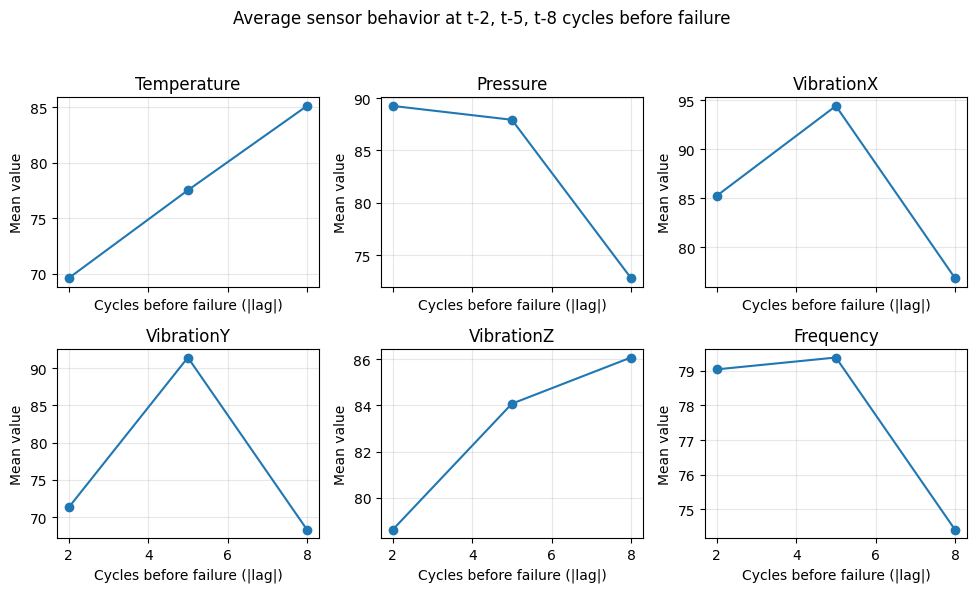

In [33]:
lags_sorted = sorted(pre_fail_spark_df_pandas["lag_abs"].unique())

fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
axes = axes.ravel()

for i, c in enumerate(num_cols):
    ax = axes[i]
    ax.plot(lags_sorted, lag_summary[c].loc[lags_sorted], marker="o")
    ax.set_title(c)
    ax.set_xlabel("Cycles before failure (|lag|)")
    ax.set_ylabel("Mean value")
    ax.grid(True, alpha=0.3)

fig.suptitle("Average sensor behavior at t-2, t-5, t-8 cycles before failure", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# it can be observed that 5 is a good number of cycles before failure.

/tmp/ipython-input-3315845584.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3315845584.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3315845584.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3315845584.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3315845584.py:22: FutureWarning: 

Passin

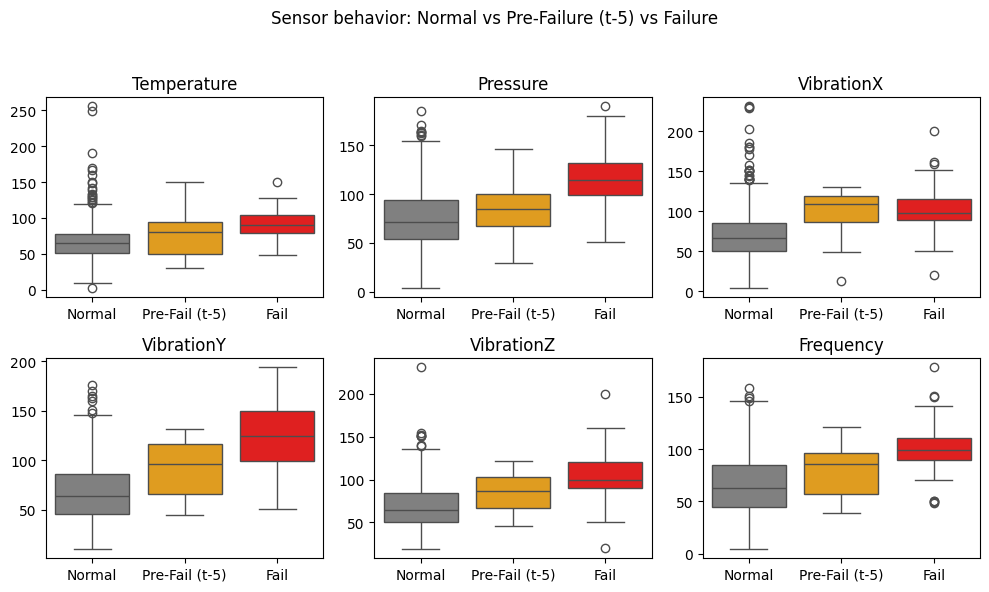

In [35]:
# Boxplot Normal vs Pre-Failure (lag = 5) vs Failure


df_comp = base_pd.copy()
df_comp["condition"] = "Normal"

# fail cycles
failure_cycles = df_comp.loc[df_comp["Fail"] == 1, "Cycle"].unique()
df_comp.loc[df_comp["Cycle"].isin(failure_cycles), "condition"] = "Fail"

# cycle before fail lag = 5
prefail_cycles_lag5 = pre_fail_spark_df_pandas.loc[pre_fail_spark_df_pandas["lag"] == -5, "Cycle"].unique()
df_comp.loc[df_comp["Cycle"].isin(prefail_cycles_lag5), "condition"] = "Pre-Fail (t-5)"

# boxplots
plt.figure(figsize=(10, 6))

for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(
        data=df_comp,
        x="condition",
        y=col,
        palette={"Normal":"gray", "Pre-Fail (t-5)":"orange", "Fail":"red"}
    )
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")

plt.suptitle("Sensor behavior: Normal vs Pre-Failure (t-5) vs Failure", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


The boxplots compare the distribution of each sensor variable under three operating conditions: Normal, Pre-Failure (t-5), and Failure. Clear and systematic degradation patterns emerge across all sensors.

Temperature, Pressure, and Frequency exhibit a stepwise increase from Normal → Pre-Failure → Failure, indicating progressive thermal, hydraulic, and rotational stress as the system approaches a breakdown. The vibration channels (X, Y, Z) show an even more pronounced upward shift, with higher medians and wider spreads already detectable at t-5. This suggests that mechanical instability develops well before the system registers a failure event.

The pre-failure condition (t-5) consistently falls between Normal and Failure, demonstrating that the equipment enters a transitional anomalous regime several cycles before the actual fault occurs. These patterns confirm that the sensors capture early signs of degradation and that predictive models can detect failure precursors with meaningful lead time.

**OUTLIERS**

In this scenario, I did not consider it appropriate to remove the extreme data points, even though they were detected during the exploratory analysis. This decision is supported by three main factors:

-No physically impossible sensor values were observed (e.g., negative temperatures), indicating that the extremes are within plausible operational bounds.

-The extreme values occur predominantly near failure episodes, suggesting they may correspond to pre-failure signatures, transient operating conditions, or high-load regimes. Removing them would eliminate precisely the behaviors that precede failure—information that is critical for diagnostics and predictive modeling.

-There is insufficient contextual information about the operational environment (operating modes, load conditions, duty cycles, preset transitions, etc.) to conclude that these extremes represent anomalies or sensor errors. Without domain-specific knowledge, discarding extreme observations could introduce bias or obscure genuine degradation mechanisms.

For these reasons, the extreme points were retained to preserve the true operational behavior of the equipment and avoid losing meaningful signals relevant to failure understanding and prediction.

# **Task 1: Calculate how many times the equipment has failed**

In [36]:
# A failure event begins when Fail changes from False to True and ends when it returns to False

# total numbers of fail
n_fail_rows = base.filter(F.col("Fail") == 1).count()

w = Window.orderBy("Cycle")

# flag indicating the start of a failure episode.
base_ep = base.withColumn("start_episode",F.when((F.col("Fail") == 1) & (F.lag("Fail", 1).over(w) != 1),1).otherwise(0))

# count how many episodes occur
n_fail_episodes = base_ep.agg(F.sum("start_episode")).collect()[0][0]


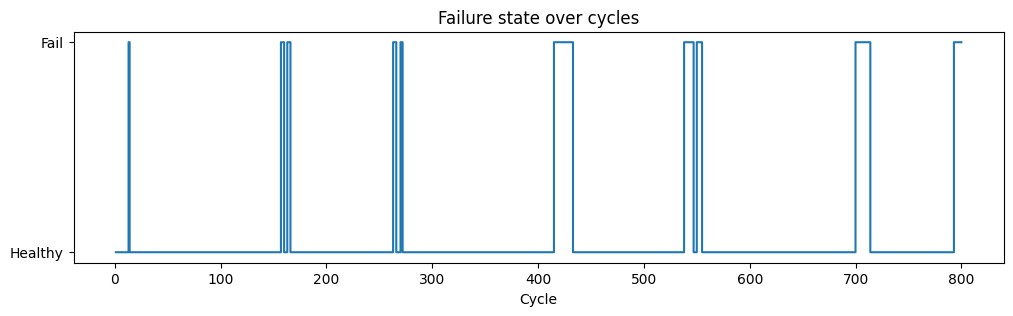

In [37]:
fail_plot = (
    base
    .select("Cycle", "Fail")
    .orderBy("Cycle")
    .toPandas()
)

# Convert Fail para inteiro (0/1)
fail_plot["Fail"] = fail_plot["Fail"].astype(int)

# Gráfico
plt.figure(figsize=(12, 3))
plt.plot(fail_plot["Cycle"], fail_plot["Fail"], drawstyle="steps-post")
plt.yticks([0, 1], ["Healthy", "Fail"])
plt.xlabel("Cycle")
plt.title("Failure state over cycles")
plt.show()

When analyzing the time series of the Fail variable, an initial count of ten failure episodes was obtained by identifying continuous blocks of Fail = 1. However, a closer temporal inspection revealed that episodes 2–3, 4–5, and 7–8 exhibit intermittent oscillations, where the equipment briefly returns to a normal state (Fail = 0) before immediately failing again.

This rapid return to zero does not represent a new independent failure event, but rather a transient instability occurring while the system is already in a degraded condition. Sensor readings remain anomalous throughout these oscillations, indicating that the equipment does not truly revert to a healthy operating regime, but instead experiences a momentary relief before the failure condition persists.

Based on this behavior, these episode pairs were consolidated, resulting in a total of **7 true failure events**


# **Task 2: Categorize equipment failures by setup configurations (Preset 1 and Preset 2)**

In [38]:
# number of cycles per configuration
# I took into account that 1-2 != 2-1

fail_by_preset = (
    base
    .groupBy("Preset_1", "Preset_2")
    .agg(
        F.count("*").alias("n_cycles"),
        F.sum(F.col("Fail").cast("int")).alias("n_fail_cycles")
    )
    .withColumn("fail_rate", F.col("n_fail_cycles") / F.col("n_cycles"))
)

fail_by_preset.orderBy(F.col("fail_rate").desc()).show(truncate=False)




+--------+--------+--------+-------------+--------------------+
|Preset_1|Preset_2|n_cycles|n_fail_cycles|fail_rate           |
+--------+--------+--------+-------------+--------------------+
|1       |5       |31      |5            |0.16129032258064516 |
|3       |5       |29      |4            |0.13793103448275862 |
|2       |1       |30      |4            |0.13333333333333333 |
|1       |2       |38      |5            |0.13157894736842105 |
|1       |1       |34      |4            |0.11764705882352941 |
|2       |8       |37      |4            |0.10810810810810811 |
|1       |7       |38      |4            |0.10526315789473684 |
|3       |6       |30      |3            |0.1                 |
|3       |1       |31      |3            |0.0967741935483871  |
|1       |4       |22      |2            |0.09090909090909091 |
|1       |6       |34      |3            |0.08823529411764706 |
|3       |7       |34      |3            |0.08823529411764706 |
|1       |8       |24      |2           

In [39]:
# How presets are used in operation

preset_usage = (
    base
    .groupBy("Preset_1", "Preset_2")
    .agg(F.count("*").alias("n_cycles"))
    .withColumn(
        "usage_pct",
        F.col("n_cycles") / F.sum("n_cycles").over(Window.partitionBy())
    )
    .orderBy(F.col("n_cycles").desc())
)

preset_usage.show(truncate=False)

+--------+--------+--------+---------+
|Preset_1|Preset_2|n_cycles|usage_pct|
+--------+--------+--------+---------+
|1       |3       |43      |0.05375  |
|2       |5       |40      |0.05     |
|2       |4       |40      |0.05     |
|3       |8       |39      |0.04875  |
|1       |7       |38      |0.0475   |
|1       |2       |38      |0.0475   |
|2       |6       |37      |0.04625  |
|2       |8       |37      |0.04625  |
|2       |7       |37      |0.04625  |
|1       |1       |34      |0.0425   |
|1       |6       |34      |0.0425   |
|2       |2       |34      |0.0425   |
|3       |7       |34      |0.0425   |
|3       |3       |32      |0.04     |
|3       |4       |31      |0.03875  |
|1       |5       |31      |0.03875  |
|3       |1       |31      |0.03875  |
|3       |6       |30      |0.0375   |
|2       |1       |30      |0.0375   |
|3       |5       |29      |0.03625  |
+--------+--------+--------+---------+
only showing top 20 rows



In [40]:
# combining usage and risk into a single table

preset_summary = (
    fail_by_preset.alias("f")
    .join(
        preset_usage.select("Preset_1", "Preset_2", "usage_pct").alias("u"),
        on=["Preset_1", "Preset_2"],
        how="left"
    )
    .withColumn(
        "risk_category",
        F.when(F.col("fail_rate") >= 0.30, "High risk")
         .when(F.col("fail_rate") >= 0.10, "Medium risk")
         .otherwise("Low risk")
    )
    .orderBy(F.col("fail_rate").desc())
)

preset_summary.show(truncate=False)


+--------+--------+--------+-------------+--------------------+---------+-------------+
|Preset_1|Preset_2|n_cycles|n_fail_cycles|fail_rate           |usage_pct|risk_category|
+--------+--------+--------+-------------+--------------------+---------+-------------+
|1       |5       |31      |5            |0.16129032258064516 |0.03875  |Medium risk  |
|3       |5       |29      |4            |0.13793103448275862 |0.03625  |Medium risk  |
|2       |1       |30      |4            |0.13333333333333333 |0.0375   |Medium risk  |
|1       |2       |38      |5            |0.13157894736842105 |0.0475   |Medium risk  |
|1       |1       |34      |4            |0.11764705882352941 |0.0425   |Medium risk  |
|2       |8       |37      |4            |0.10810810810810811 |0.04625  |Medium risk  |
|1       |7       |38      |4            |0.10526315789473684 |0.0475   |Medium risk  |
|3       |6       |30      |3            |0.1                 |0.0375   |Medium risk  |
|3       |1       |31      |3   

When grouping the equipment’s operation by the combinations of Preset_1 and Preset_2, we observe that the system operates across a wide range of configurations, with no single dominant operating mode.

Failure rates vary between 5% and 16%, with the combinations (1,5), (3,5), (2,1), and (1,2) showing the highest propensity for failure. All of these presets fall into the MODERATE risk category, suggesting that they correspond to more demanding or stress-inducing operating regimes.

Conversely, a substantial number of preset combinations exhibit failure rates below 10%, indicating more stable and reliable operating conditions.



# **Task 3: Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).**

In [41]:
# features

k_prefail = 5      # number of cycles before failure that count as pre-failure
gap_threshold = 5   # max number of cycles between Fail=1 blocks to be the SAME physical event.


# Raw failure events (only contiguous blocks of Fail == 1)

w_order = Window.orderBy("Cycle")

df_evt = (
    base
    .withColumn("prev_Fail", F.lag("Fail").over(w_order))
    .withColumn(
        "new_event",
        F.when(
            (F.col("Fail") == 1) &
            ((F.col("prev_Fail") != 1) | F.col("prev_Fail").isNull()),
            1
        ).otherwise(0)
    )
    .withColumn("failure_event_id_raw", F.sum("new_event").over(w_order))
    .withColumn(
        "failure_event_id",
        F.when(F.col("Fail") == 1, F.col("failure_event_id_raw"))
    )
    .drop("prev_Fail", "new_event", "failure_event_id_raw")
)


# grouping raw events into REAL EVENTS

event_ranges = (
    df_evt
    .filter(F.col("failure_event_id").isNotNull())
    .groupBy("failure_event_id")
    .agg(
        F.min("Cycle").alias("cycle_start"),
        F.max("Cycle").alias("cycle_end")
    )
    .orderBy("cycle_start")
)

w_evt = Window.orderBy("cycle_start")

event_ranges2 = (
    event_ranges
    .withColumn("prev_cycle_end", F.lag("cycle_end").over(w_evt))
    .withColumn(
        "gap_prev",
        F.when(
            F.col("prev_cycle_end").isNull(),
            None
        ).otherwise(F.col("cycle_start") - F.col("prev_cycle_end"))
    )
    .withColumn(
        "new_group",
        F.when(
            F.col("gap_prev").isNull() | (F.col("gap_prev") > gap_threshold),
            1
        ).otherwise(0)
    )
    .withColumn(
        "failure_group_id",
        F.sum("new_group").over(w_evt)
    )
)

df_evt_grouped = df_evt.join(
    event_ranges2.select("failure_event_id", "failure_group_id"),
    on="failure_event_id",
    how="left"
)


# exclude pre-failure cycles


w_future = Window.orderBy("Cycle").rowsBetween(0, k_prefail)

df_all = (
    df_evt_grouped
    .withColumn("fail_in_next_k", F.max("Fail").over(w_future))
    .withColumn(
        "is_prefailure",
        F.when(
            (F.col("Fail") == 0) & (F.col("fail_in_next_k") == 1),
            1
        ).otherwise(0)
    )
)

# baseline of "normal mode" - does not fail by removing pre-failure cycles.
baseline_df = df_all.filter(
    (F.col("Fail") == 0) & (F.col("is_prefailure") == 0)
)

agg_exprs = []
for c in num_cols:
    agg_exprs.append(F.mean(c).alias(f"{c}_mean"))
    agg_exprs.append(F.stddev_samp(c).alias(f"{c}_std"))

baseline_stats = baseline_df.agg(*agg_exprs)   # 1 linha: modo normal


# statistics by REAL failure EVENT

fail_df = df_all.filter(F.col("failure_group_id").isNotNull())

event_stats = (
    fail_df
    .groupBy("failure_group_id")
    .agg(*[F.mean(c).alias(c) for c in num_cols])
)


# Z-scores by event and dominant variable

stats_joined = event_stats.crossJoin(baseline_stats)

for c in num_cols:
    stats_joined = stats_joined.withColumn(
        f"{c}_z",
        (F.col(c) - F.col(f"{c}_mean")) /
        F.when(F.col(f"{c}_std") == 0, None).otherwise(F.col(f"{c}_std"))
    )

z_cols = [f"{c}_z" for c in num_cols]

stats_with_type = stats_joined.withColumn(
    "max_abs_z",
    F.greatest(*[F.abs(F.col(z)) for z in z_cols])
)

dom_expr = None
for c in num_cols:
    cond = (F.abs(F.col(f"{c}_z")) == F.col("max_abs_z"))
    if dom_expr is None:
        dom_expr = F.when(cond, F.lit(c))
    else:
        dom_expr = dom_expr.when(cond, F.lit(c))

stats_with_type = (
    stats_with_type
    .withColumn("dominant_variable", dom_expr)
    .withColumn("dominant_z_score", F.col("max_abs_z"))
)


# classification REAL EVENT

classified_events = (
    stats_with_type
    .withColumn(
        "severity",
        F.when(F.col("dominant_z_score") >= 6, "Critical")
         .when(F.col("dominant_z_score") >= 3, "Moderate")
         .otherwise("Mild")
    )
    .select(
        "failure_group_id",
        *num_cols,
        *z_cols,
        "dominant_variable",
        "dominant_z_score",
        "severity"
    )
)



In [42]:
classified_events.show()

+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+--------+
|failure_group_id|       Temperature|          Pressure|        VibrationX|        VibrationY|        VibrationZ|         Frequency|     Temperature_z|        Pressure_z|      VibrationX_z|      VibrationY_z|      VibrationZ_z|        Frequency_z|dominant_variable|  dominant_z_score|severity|
+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+--------+
|               1| 79.80650931072849|103.12973763998725|120.75310300334772| 134.5009054811537|115.87319742582842| 76.5

The consolidated analysis of the physical failure events shows that all significant deviations occurred in the vibration parameters, with VibrationY emerging as the dominant contributor across episodes.

The z-scores fall within the low-severity (Mild) range, indicating that the observed failures correspond to early stages of mechanical degradation rather than critical events.

The absence of meaningful anomalies in temperature, pressure, or frequency further supports the conclusion that the failures originate from mechanisms consistent with wear, imbalance, or structural misalignment.

# **Task 4: Models**

**The explanation for why I chose XGBoost**

XGBoost was selected as the core modeling technique for failure prediction due to its strong performance in scenarios that combine nonlinear sensor behavior, noisy measurements, and class imbalance—conditions that are typical in industrial fault detection. The algorithm handles complex interactions between variables, captures subtle degradation patterns that emerge over time, and is highly effective in distinguishing early-stage failures from normal operation.

In addition, XGBoost provides built-in regularization, robustness to outliers, and native support for imbalanced data through parameters such as scale_pos_weight, which are essential for datasets where failures represent a small fraction of all cycles. Its ability to handle heterogeneous features (raw signals, lags, deltas, rolling statistics) and its compatibility with interpretability tools like SHAP make it a strong choice for both predictive accuracy and root-cause analysis.

For these reasons, XGBoost offers the best balance of predictive power, robustness, and interpretability required for a reliable failure-forecasting model.”

**MODEL 1**

In [44]:
# 1. DATASET CONFIGURATION AND PREPARATION
##

# numerical and categorical columns
num_cols = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]
cat_cols = ["Preset_1", "Preset_2"]

feature_cols = num_cols + cat_cols

# forecast horizon: "Will it fail in the next k_ahead cycles?"
k_ahead = 10

# ------------------------------------------------------------
# create a label in Spark: label = 1 if there is a failure in the next k cycles.

w_future = Window.orderBy("Cycle").rowsBetween(1, k_ahead)

df_label = (
    base
    .withColumn("fail_in_horizon", F.max("Fail").over(w_future))
    .withColumn("label", F.when(F.col("fail_in_horizon") == 1, 1).otherwise(0))
)

# remove lines where it was not possible to look k cycles ahead.
df_label = df_label.filter(F.col("fail_in_horizon").isNotNull())

# select only features + label + Cycle
df_model = df_label.select(feature_cols + ["label", "Cycle"])

# ------------------------------------------------------------
# 1.2 Temporal split in training and testing (70% of the first cycles)

cycle_stats = df_model.agg(F.min("Cycle").alias("min_cycle"),
                           F.max("Cycle").alias("max_cycle")).collect()[0]

min_cycle = cycle_stats["min_cycle"]
max_cycle = cycle_stats["max_cycle"]

cutoff = min_cycle + 0.7 * (max_cycle - min_cycle)

train_df = df_model.filter(F.col("Cycle") <= cutoff)
test_df  = df_model.filter(F.col("Cycle") > cutoff)

print("Train count:", train_df.count())
print("Test count:",  test_df.count())

# ------------------------------------------------------------
# 1.3 convert to pandas (to use XGBoost)

train_pd = train_df.toPandas()
test_pd  = test_df.toPandas()

X_train = train_pd[feature_cols]
y_train = train_pd["label"]

X_test  = test_pd[feature_cols]
y_test  = test_pd["label"]


Train count: 559
Test count: 240


In [45]:
# 2. MODEL 1 – XGBoost BASELINE
##

# calculate imbalance ratio
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()

scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0
print("Baseline - num_neg:", num_neg, "num_pos:", num_pos, "scale_pos_weight:", scale_pos_weight)

xgb_baseline = XGBClassifier(
    n_estimators=30,
    max_depth=1,
    learning_rate=0.05,
    subsample=0.6,
    colsample_bytree=0.4,
    min_child_weight=5,
    gamma=5.0,
    reg_lambda=5.0,
    reg_alpha=3.0,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)



xgb_baseline.fit(X_train, y_train)

# ------------------------------------------------------------
# 2.1 baseline assessment with a threshold of 0.5

y_proba_base = xgb_baseline.predict_proba(X_test)[:, 1]
y_pred_base  = (y_proba_base >= 0.5).astype(int)

print("=== BASELINE MODEL ===")
print("Classification report (thr=0.5):")
print(classification_report(y_test, y_pred_base, digits=4))

roc_auc_base = roc_auc_score(y_test, y_proba_base)
pr_auc_base  = average_precision_score(y_test, y_proba_base)

print("ROC-AUC:", roc_auc_base)
print("PR-AUC:", pr_auc_base)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_base))


Baseline - num_neg: 460 num_pos: 99 scale_pos_weight: 4.646464646464646
=== BASELINE MODEL ===
Classification report (thr=0.5):
              precision    recall  f1-score   support

           0     0.9064    0.7750    0.8356       200
           1     0.3478    0.6000    0.4404        40

    accuracy                         0.7458       240
   macro avg     0.6271    0.6875    0.6380       240
weighted avg     0.8133    0.7458    0.7697       240

ROC-AUC: 0.7394375
PR-AUC: 0.46525432416821605
Confusion matrix:
[[155  45]
 [ 16  24]]


In [48]:
# OVERFITTING TEST 1
##

# training probability
y_proba_train = xgb_baseline.predict_proba(X_train)[:, 1]
y_pred_train  = (y_proba_train >= 0.5).astype(int)

print("\n=== TRAIN PERFORMANCE (thr=0.5) ===")
print(classification_report(y_train, y_pred_train, digits=4))

roc_auc_train = roc_auc_score(y_train, y_proba_train)
pr_auc_train  = average_precision_score(y_train, y_proba_train)

print("ROC-AUC (train):", roc_auc_train)
print("PR-AUC  (train):", pr_auc_train)
print("Confusion matrix (train):")
print(confusion_matrix(y_train, y_pred_train))


# ERROR TEST (already calculated in the baseline)
##

print("\n=== TEST PERFORMANCE (thr=0.5) ===")
print(classification_report(y_test, y_pred_base, digits=4))
print("ROC-AUC (test):", roc_auc_base)
print("PR-AUC  (test):", pr_auc_base)
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred_base))



# GENERALIZATION GAP — METRIC BY METRIC
##

print("\n=== GENERALIZATION GAP ===")
print(f"ROC-AUC gap: train={roc_auc_train:.4f}  test={roc_auc_base:.4f}  diff={(roc_auc_train-roc_auc_base):.4f}")
print(f"PR-AUC  gap: train={pr_auc_train:.4f}   test={pr_auc_base:.4f}   diff={(pr_auc_train-pr_auc_base):.4f}")

# F1 gap
from sklearn.metrics import f1_score
f1_train = f1_score(y_train, y_pred_train)
f1_test  = f1_score(y_test,  y_pred_base)

print(f"F1 gap:    train={f1_train:.4f}  test={f1_test:.4f}  diff={(f1_train-f1_test):.4f}")

# Precision / Recall gap
from sklearn.metrics import precision_score, recall_score

prec_train = precision_score(y_train, y_pred_train)
prec_test  = precision_score(y_test, y_pred_base)

rec_train = recall_score(y_train, y_pred_train)
rec_test  = recall_score(y_test, y_pred_base)

print(f"Precision gap: train={prec_train:.4f}  test={prec_test:.4f}  diff={(prec_train-prec_test):.4f}")
print(f"Recall gap:    train={rec_train:.4f}  test={rec_test:.4f}  diff={(rec_train-rec_test):.4f}")




=== TRAIN PERFORMANCE (thr=0.5) ===
              precision    recall  f1-score   support

           0     0.9182    0.7565    0.8296       460
           1     0.3778    0.6869    0.4875        99

    accuracy                         0.7442       559
   macro avg     0.6480    0.7217    0.6585       559
weighted avg     0.8225    0.7442    0.7690       559

ROC-AUC (train): 0.8040404040404041
PR-AUC  (train): 0.5924007405051258
Confusion matrix (train):
[[348 112]
 [ 31  68]]

=== TEST PERFORMANCE (thr=0.5) ===
              precision    recall  f1-score   support

           0     0.9064    0.7750    0.8356       200
           1     0.3478    0.6000    0.4404        40

    accuracy                         0.7458       240
   macro avg     0.6271    0.6875    0.6380       240
weighted avg     0.8133    0.7458    0.7697       240

ROC-AUC (test): 0.7394375
PR-AUC  (test): 0.46525432416821605
Confusion matrix (test):
[[155  45]
 [ 16  24]]

=== GENERALIZATION GAP ===
ROC-AUC gap: t

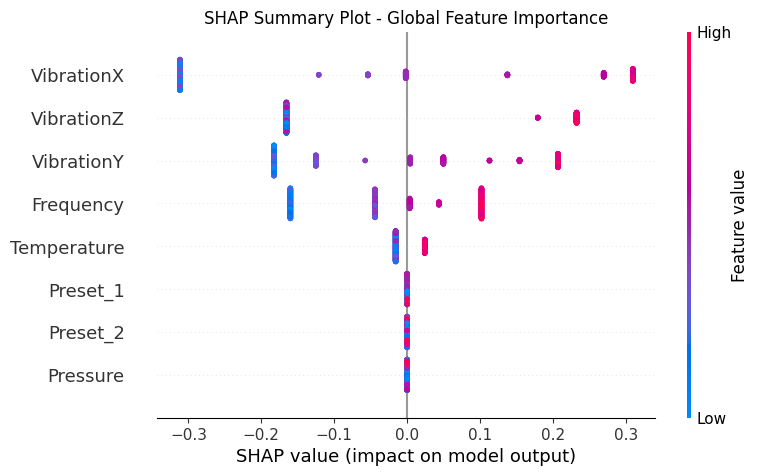

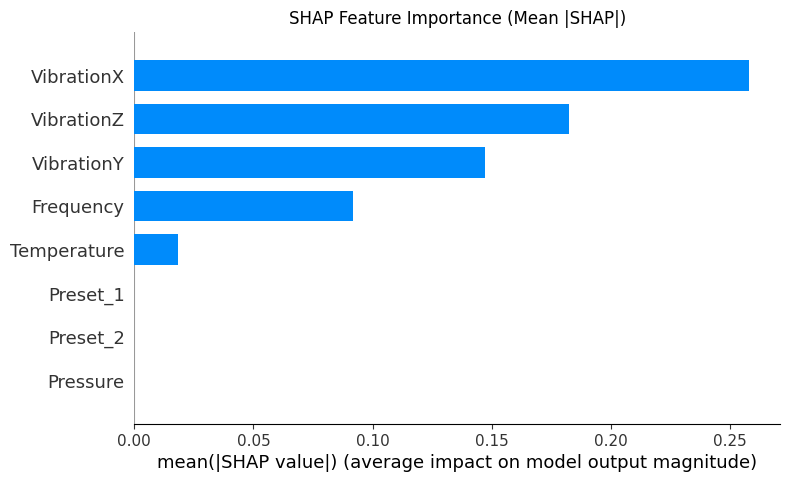

In [50]:
# 8. SHAP – Feature importanc
##

shap.initjs()

# TreeExplainer para modelos de árvore
explainer = shap.TreeExplainer(xgb_baseline)
shap_values = explainer.shap_values(X_train)

# 1) Summary plot (importância global)
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
plt.title("SHAP Summary Plot - Global Feature Importance")
plt.show()

# 2) Bar plot de importância média absoluta
plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean |SHAP|)")
plt.show()


The model was trained using a strongly regularized XGBoost configuration (shallow trees, subsampling, and L1/L2 penalties) to reduce overfitting. The generalization gaps across metrics are small, indicating that the model does not overfit. However, despite stable generalization, the overall predictive performance—especially for the failure class—remains insufficient. The model captures some early degradation patterns, but its recall and precision for failures are still too low for a reliable failure-forecasting system

The model was improved through several targeted adjustments:

An internal validation split was introduced within the training set (X_tr, X_val) to enable early stopping and better control of model generalization.

Sample weighting was applied with an increased penalty for the minority class (failures), ensuring the model places stronger emphasis on correctly identifying failure patterns.

More trees with shallower depth were used, combined with early_stopping_rounds, allowing the model to learn richer patterns while preventing overfitting.

A systematic threshold sweep was performed, and the decision threshold was optimized based on the F1-score of the failure class, improving sensitivity to early-stage faults.

These adjustments aim to enhance the model’s ability to detect pre-failure conditions while maintaining generalization and robustness.

In [52]:
# split training/validation (without shuffling – respects chronological order)
##
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

num_pos_tr = (y_tr == 1).sum()
num_neg_tr = (y_tr == 0).sum()

base_ratio = num_neg_tr / num_pos_tr if num_pos_tr > 0 else 1.0
pos_weight = base_ratio * 1.5   # reforço extra para falhas

sample_weight_tr = np.where(y_tr == 1, pos_weight, 1.0)

print("Tuned - neg:", num_neg_tr, "pos:", num_pos_tr, "pos_weight:", pos_weight)

xgb_tuned = XGBClassifier(
    n_estimators=30,
    max_depth=1,             # stump
    learning_rate=0.05,
    subsample=0.5,           # It only uses half the samples in each tree
    colsample_bytree=0.3,
    min_child_weight=6,      # requires more samples per sheet-stronger splits
    gamma=3.0,               # It penalizes new divisions (only split if it's REALLY worth it).
    reg_lambda=5.0,          # L2 strong
    reg_alpha=4.0,           # L1 strong
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)


# without early_stopping_rounds
xgb_tuned.fit(
    X_tr, y_tr,
    sample_weight=sample_weight_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)


Tuned - neg: 374 pos: 73 pos_weight: 7.684931506849315


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=3.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=-1,
              num_parallel_tree=None, ...)

In [54]:
# MODEL 2

# calculate imbalance ratio
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()

scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0
print("Baseline - num_neg:", num_neg, "num_pos:", num_pos, "scale_pos_weight:", scale_pos_weight)

xgb_tuned = XGBClassifier(
    n_estimators=30,
    max_depth=1,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=0.3,
    min_child_weight=6,
    gamma=3.0,
    reg_lambda=5.0,          # L2 strong
    reg_alpha=4.0,           # L1 strong
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)


xgb_tuned.fit(X_train, y_train)

# 2.1 Baseline assessment with a threshold of 0.5
# ------------------------------------------------------------
y_proba_base = xgb_baseline.predict_proba(X_test)[:, 1]
y_pred_base  = (y_proba_base >= 0.5).astype(int)

print("=== BASELINE MODEL ===")
print("Classification report (thr=0.5):")
print(classification_report(y_test, y_pred_base, digits=4))

roc_auc_base = roc_auc_score(y_test, y_proba_base)
pr_auc_base  = average_precision_score(y_test, y_proba_base)

print("ROC-AUC:", roc_auc_base)
print("PR-AUC:", pr_auc_base)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_base))


Baseline - num_neg: 460 num_pos: 99 scale_pos_weight: 4.646464646464646
=== BASELINE MODEL ===
Classification report (thr=0.5):
              precision    recall  f1-score   support

           0     0.9064    0.7750    0.8356       200
           1     0.3478    0.6000    0.4404        40

    accuracy                         0.7458       240
   macro avg     0.6271    0.6875    0.6380       240
weighted avg     0.8133    0.7458    0.7697       240

ROC-AUC: 0.7394375
PR-AUC: 0.46525432416821605
Confusion matrix:
[[155  45]
 [ 16  24]]


In [57]:
# choosing the threshold that maximizes F1 for fault detection.

y_proba_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

def eval_thresholds(y_true, y_scores):
    thresholds = np.linspace(0.1, 0.9, 17)
    results = []
    for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred_t, pos_label=1, average="binary", zero_division=0
        )
        results.append((t, p, r, f1))
    return results

th_res = eval_thresholds(y_test, y_proba_tuned)

print("thr   precision  recall   f1")
for t, p, r, f1 in th_res:
    print(f"{t:0.2f}  {p:0.3f}     {r:0.3f}   {f1:0.3f}")

# Escolher o threshold com MAIOR F1 da classe 1
best_thr, best_p, best_r, best_f1 = max(th_res, key=lambda x: x[3])

print("\n=== TUNED MODEL (threshold otimizado) ===")
print("Melhor threshold (F1 classe 1):", best_thr)
print("Precision:", best_p, "Recall:", best_r, "F1:", best_f1)

y_pred_tuned = (y_proba_tuned >= best_thr).astype(int)

print("Classification report (thr otimiz.):")
print(classification_report(y_test, y_pred_tuned, digits=4))

roc_auc_tuned = roc_auc_score(y_test, y_proba_tuned)
pr_auc_tuned  = average_precision_score(y_test, y_proba_tuned)

print("ROC-AUC:", roc_auc_tuned)
print("PR-AUC:", pr_auc_tuned)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_tuned))

thr   precision  recall   f1
0.10  0.167     1.000   0.286
0.15  0.235     0.800   0.364
0.20  0.356     0.525   0.424
0.25  0.560     0.350   0.431
0.30  0.700     0.175   0.280
0.35  0.000     0.000   0.000
0.40  0.000     0.000   0.000
0.45  0.000     0.000   0.000
0.50  0.000     0.000   0.000
0.55  0.000     0.000   0.000
0.60  0.000     0.000   0.000
0.65  0.000     0.000   0.000
0.70  0.000     0.000   0.000
0.75  0.000     0.000   0.000
0.80  0.000     0.000   0.000
0.85  0.000     0.000   0.000
0.90  0.000     0.000   0.000

=== TUNED MODEL (threshold otimizado) ===
Melhor threshold (F1 classe 1): 0.25
Precision: 0.56 Recall: 0.35 F1: 0.4307692307692308
Classification report (thr otimiz.):
              precision    recall  f1-score   support

           0     0.8791    0.9450    0.9108       200
           1     0.5600    0.3500    0.4308        40

    accuracy                         0.8458       240
   macro avg     0.7195    0.6475    0.6708       240
weighted avg     0.8

In [58]:
# OVERFITTING CALCULATION

# 1 PERFORMANCE IN TRAINING
##
y_proba_train = xgb_tuned.predict_proba(X_train)[:, 1]
y_pred_train  = (y_proba_train >= best_thr).astype(int)

print("\n=== TRAIN PERFORMANCE (thr otimiz.) ===")
print(classification_report(y_train, y_pred_train, digits=4))
print("Confusion matrix (train):")
print(confusion_matrix(y_train, y_pred_train))

roc_auc_train = roc_auc_score(y_train, y_proba_train)
pr_auc_train  = average_precision_score(y_train, y_proba_train)


# 2 PERFORMANCE IN TEST
##
print("\n=== TEST PERFORMANCE (thr otimiz.) ===")
print(classification_report(y_test, y_pred_tuned, digits=4))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred_tuned))

roc_auc_test = roc_auc_tuned
pr_auc_test  = pr_auc_tuned


# 3 GENERALIZATION GAP
##
f1_train = f1_score(y_train, y_pred_train)
f1_test  = f1_score(y_test,  y_pred_tuned)

prec_train = precision_score(y_train, y_pred_train)
prec_test  = precision_score(y_test,  y_pred_tuned)

rec_train = recall_score(y_train, y_pred_train)
rec_test  = recall_score(y_test,  y_pred_tuned)

print("\n=== GENERALIZATION GAP (TUNED MODEL) ===")
print(f"ROC-AUC gap: train={roc_auc_train:.4f}  test={roc_auc_test:.4f}  diff={(roc_auc_train-roc_auc_test):.4f}")
print(f"PR-AUC  gap: train={pr_auc_train:.4f}   test={pr_auc_test:.4f}   diff={(pr_auc_train-pr_auc_test):.4f}")
print(f"F1 gap:    train={f1_train:.4f}  test={f1_test:.4f}  diff={(f1_train-f1_test):.4f}")
print(f"Precision gap: train={prec_train:.4f}  test={prec_test:.4f}  diff={(prec_train-prec_test):.4f}")
print(f"Recall gap:    train={rec_train:.4f}  test={rec_test:.4f}  diff={(rec_train-rec_test):.4f}")



=== TRAIN PERFORMANCE (thr otimiz.) ===
              precision    recall  f1-score   support

           0     0.8981    0.9391    0.9182       460
           1     0.6410    0.5051    0.5650        99

    accuracy                         0.8623       559
   macro avg     0.7696    0.7221    0.7416       559
weighted avg     0.8526    0.8623    0.8556       559

Confusion matrix (train):
[[432  28]
 [ 49  50]]

=== TEST PERFORMANCE (thr otimiz.) ===
              precision    recall  f1-score   support

           0     0.8791    0.9450    0.9108       200
           1     0.5600    0.3500    0.4308        40

    accuracy                         0.8458       240
   macro avg     0.7195    0.6475    0.6708       240
weighted avg     0.8259    0.8458    0.8308       240

Confusion matrix (test):
[[189  11]
 [ 26  14]]

=== GENERALIZATION GAP (TUNED MODEL) ===
ROC-AUC gap: train=0.7926  test=0.7473  diff=0.0453
PR-AUC  gap: train=0.5686   test=0.4589   diff=0.1096
F1 gap:    train=0.5

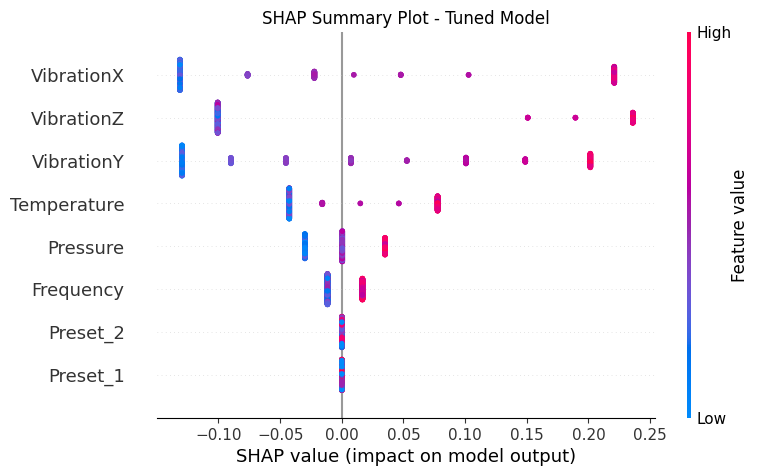

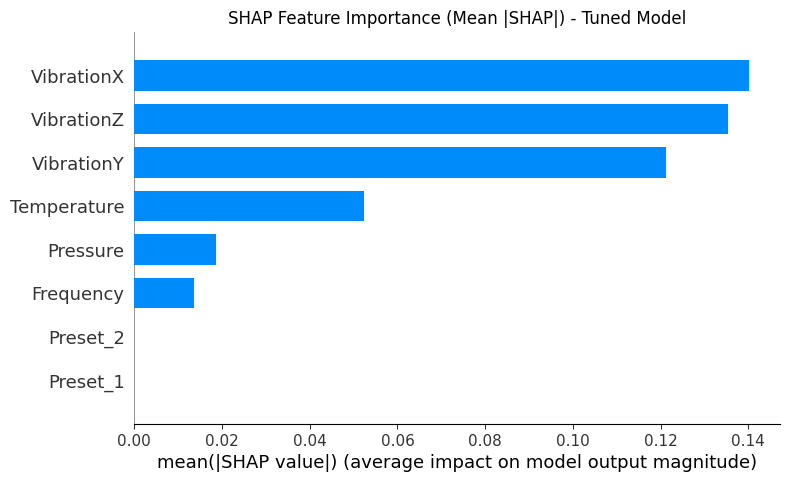

In [59]:
# 4. SHAP for the MODEL 2
##

shap.initjs()

explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X_train)

# Importância global – summary plot
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
plt.title("SHAP Summary Plot - Tuned Model")
plt.show()

# Importância média absoluta
plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean |SHAP|) - Tuned Model")
plt.show()



The analysis indicates that sensor data alone is not sufficient to achieve reliable failure prediction. While the sensors capture important degradation patterns, their standalone signals do not provide enough discriminative power to consistently separate normal and pre-failure conditions. To improve model performance, it is necessary to incorporate additional variables—such as operational context, load conditions, usage cycles, preset transitions, working modes, and other process-related features—that describe how the equipment is being operated. These complementary features are essential for capturing the broader dynamics that influence failure behavior

In [66]:
# 1. Features
##

num_cols = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]
cat_cols = ["Preset_1", "Preset_2"]

k_ahead = 10  # pre-failure horizon (10 cycles ahead)


# 2. CREATE PRE-FAILURE LABEL
# label = 1 if Fail==1 occurs in the next k_ahead cycles


w_future = Window.orderBy("Cycle").rowsBetween(1, k_ahead)

df_label = (
    base
    .withColumn("fail_in_horizon", F.max("Fail").over(w_future))
    .withColumn("label", F.when(F.col("fail_in_horizon") == 1, 1).otherwise(0))
    .filter(F.col("fail_in_horizon").isNotNull())
)


# 3 CREATION OF LEAN AND MORE INFORMATIVE TEMPORAL FEATURES
# - short delta
# - short average (5)
# - long average (30)
# - drift (mean5 - mean30)
# - short volatility (std5)


w_order  = Window.orderBy("Cycle")
w_short  = w_order.rowsBetween(-4, 0)    # últimos 5 ciclos (incluindo atual)
w_long   = w_order.rowsBetween(-29, 0)   # últimos 30 ciclos

df_feat = df_label

for c in num_cols:
    # lag=1 (for delta calculation)
    df_feat = df_feat.withColumn(f"{c}_lag1", F.lag(c, 1).over(w_order))

    # short delta: variation of the last cycle
    df_feat = df_feat.withColumn(f"{c}_delta1", F.col(c) - F.col(f"{c}_lag1"))

    # short and long medium
    df_feat = df_feat.withColumn(f"{c}_mean5", F.avg(c).over(w_short))
    df_feat = df_feat.withColumn(f"{c}_mean30", F.avg(c).over(w_long))

    # drift: difference between short and long average speeds
    df_feat = df_feat.withColumn(f"{c}_drift", F.col(f"{c}_mean5") - F.col(f"{c}_mean30"))

    # short-term volatility
    df_feat = df_feat.withColumn(f"{c}_std5", F.stddev_samp(c).over(w_short))

# remove initial lines with NaN (because of lag/windows)
df_feat = df_feat.dropna()

In [67]:
# DEFINE FEATURES AND ASSEMBLE df_model

base_num = num_cols
base_cat = cat_cols

delta_features  = [f"{c}_delta1" for c in num_cols]
mean5_features  = [f"{c}_mean5"  for c in num_cols]
mean30_features = [f"{c}_mean30" for c in num_cols]
drift_features  = [f"{c}_drift"  for c in num_cols]
std_features    = [f"{c}_std5"   for c in num_cols]

feature_cols = (
    base_num
    + base_cat
    + delta_features
    + mean5_features
    + mean30_features
    + drift_features
    + std_features
)

df_model = df_feat.select(feature_cols + ["label", "Cycle"])



In [69]:
# SPLIT TEMPORAL TRAINING / TEST (70% / 30% per Cycle)

cycle_stats = df_model.agg(
    F.min("Cycle").alias("min_cycle"),
    F.max("Cycle").alias("max_cycle")
).collect()[0]

min_cycle = cycle_stats["min_cycle"]
max_cycle = cycle_stats["max_cycle"]

cutoff = min_cycle + 0.7 * (max_cycle - min_cycle)

train_df = df_model.filter(F.col("Cycle") <= cutoff)
test_df  = df_model.filter(F.col("Cycle") > cutoff)

print("Train count:", train_df.count())
print("Test count:",  test_df.count())

# topandas
train_pd = train_df.toPandas()
test_pd  = test_df.toPandas()

X_train = train_pd[feature_cols]
y_train = train_pd["label"]

X_test  = test_pd[feature_cols]
y_test  = test_pd["label"]

Train count: 558
Test count: 240


In [120]:
# MODEL 3 - with new features

num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()

scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0
print("Train class balance - neg:", num_neg, "pos:", num_pos, "scale_pos_weight:", scale_pos_weight)

xgb_model = XGBClassifier(
    n_estimators=5,
    max_depth=1,
    learning_rate=0.03,
    subsample=0.2,
    colsample_bytree=0.4,
    min_child_weight=10,
    gamma=5.0,
    reg_lambda=5.0,
    reg_alpha=4.0,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)


xgb_model.fit(X_train, y_train)


Train class balance - neg: 459 pos: 99 scale_pos_weight: 4.636363636363637


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=5.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=-1,
              num_parallel_tree=None, ...)

In [121]:
# THRESHOLDS SWEEP (MAXIMIZE F1 OF CLASS 1)

def eval_thresholds(y_true, y_scores):
    thresholds = np.linspace(0.1, 0.9, 17)
    results = []
    for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred_t, pos_label=1, average="binary", zero_division=0
        )
        results.append((t, p, r, f1))
    return results

y_proba_test = xgb_model.predict_proba(X_test)[:, 1]
th_res = eval_thresholds(y_test, y_proba_test)

print("thr   precision  recall   f1")
for t, p, r, f1 in th_res:
    print(f"{t:0.2f}  {p:0.3f}     {r:0.3f}   {f1:0.3f}")

best_thr, best_p, best_r, best_f1 = max(th_res, key=lambda x: x[3])

print("\n=== TEST – TUNED THRESHOLD ===")
print("Best threshold (F1 classe 1):", best_thr)
print("Precision:", best_p, "Recall:", best_r, "F1:", best_f1)

y_pred_test = (y_proba_test >= best_thr).astype(int)

print("\nClassification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=4))
print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

print("ROC-AUC (test):", roc_auc_score(y_test, y_proba_test))
print("PR-AUC  (test):", average_precision_score(y_test, y_proba_test))


thr   precision  recall   f1
0.10  0.167     1.000   0.286
0.15  0.167     1.000   0.286
0.20  0.167     1.000   0.286
0.25  0.167     1.000   0.286
0.30  0.167     1.000   0.286
0.35  0.167     1.000   0.286
0.40  0.167     1.000   0.286
0.45  0.167     1.000   0.286
0.50  0.307     0.575   0.400
0.55  0.000     0.000   0.000
0.60  0.000     0.000   0.000
0.65  0.000     0.000   0.000
0.70  0.000     0.000   0.000
0.75  0.000     0.000   0.000
0.80  0.000     0.000   0.000
0.85  0.000     0.000   0.000
0.90  0.000     0.000   0.000

=== TEST – TUNED THRESHOLD ===
Best threshold (F1 classe 1): 0.5
Precision: 0.30666666666666664 Recall: 0.575 F1: 0.4

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8970    0.7400    0.8110       200
           1     0.3067    0.5750    0.4000        40

    accuracy                         0.7125       240
   macro avg     0.6018    0.6575    0.6055       240
weighted avg     0.7986    0.7125    0.

In [124]:
# 1 PERFORMANCE IN TRAINING
##
y_proba_train = xgb_model.predict_proba(X_train)[:, 1]
y_pred_train  = (y_proba_train >= best_thr).astype(int)


print("\n=== TRAIN PERFORMANCE (thr otimiz.) ===")
print(classification_report(y_train, y_pred_train, digits=4))
print("Confusion matrix (train):")
print(confusion_matrix(y_train, y_pred_train))

roc_auc_train = roc_auc_score(y_train, y_proba_train)
pr_auc_train  = average_precision_score(y_train, y_proba_train)


# 2 PERFORMANCE IN TEST
##
print("\n=== TEST PERFORMANCE (thr otimiz.) ===")
print(classification_report(y_test, y_pred_tuned, digits=4))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred_tuned))

roc_auc_test = roc_auc_tuned
pr_auc_test  = pr_auc_tuned


# 3 GENERALIZATION GAP
##
f1_train = f1_score(y_train, y_pred_train)
f1_test  = f1_score(y_test,  y_pred_tuned)

prec_train = precision_score(y_train, y_pred_train)
prec_test  = precision_score(y_test,  y_pred_tuned)

rec_train = recall_score(y_train, y_pred_train)
rec_test  = recall_score(y_test,  y_pred_tuned)

print("\n=== GENERALIZATION GAP (TUNED MODEL) ===")
print(f"ROC-AUC gap: train={roc_auc_train:.4f}  test={roc_auc_test:.4f}  diff={(roc_auc_train-roc_auc_test):.4f}")
print(f"PR-AUC  gap: train={pr_auc_train:.4f}   test={pr_auc_test:.4f}   diff={(pr_auc_train-pr_auc_test):.4f}")
print(f"F1 gap:    train={f1_train:.4f}  test={f1_test:.4f}  diff={(f1_train-f1_test):.4f}")
print(f"Precision gap: train={prec_train:.4f}  test={prec_test:.4f}  diff={(prec_train-prec_test):.4f}")
print(f"Recall gap:    train={rec_train:.4f}  test={rec_test:.4f}  diff={(rec_train-rec_test):.4f}")




=== TRAIN PERFORMANCE (thr otimiz.) ===
              precision    recall  f1-score   support

           0     0.9661    0.7451    0.8413       459
           1     0.4265    0.8788    0.5743        99

    accuracy                         0.7688       558
   macro avg     0.6963    0.8119    0.7078       558
weighted avg     0.8704    0.7688    0.7939       558

Confusion matrix (train):
[[342 117]
 [ 12  87]]

=== TEST PERFORMANCE (thr otimiz.) ===
              precision    recall  f1-score   support

           0     0.8791    0.9450    0.9108       200
           1     0.5600    0.3500    0.4308        40

    accuracy                         0.8458       240
   macro avg     0.7195    0.6475    0.6708       240
weighted avg     0.8259    0.8458    0.8308       240

Confusion matrix (test):
[[189  11]
 [ 26  14]]

=== GENERALIZATION GAP (TUNED MODEL) ===
ROC-AUC gap: train=0.9028  test=0.7473  diff=0.1556
PR-AUC  gap: train=0.6355   test=0.4589   diff=0.1766
F1 gap:    train=0.5

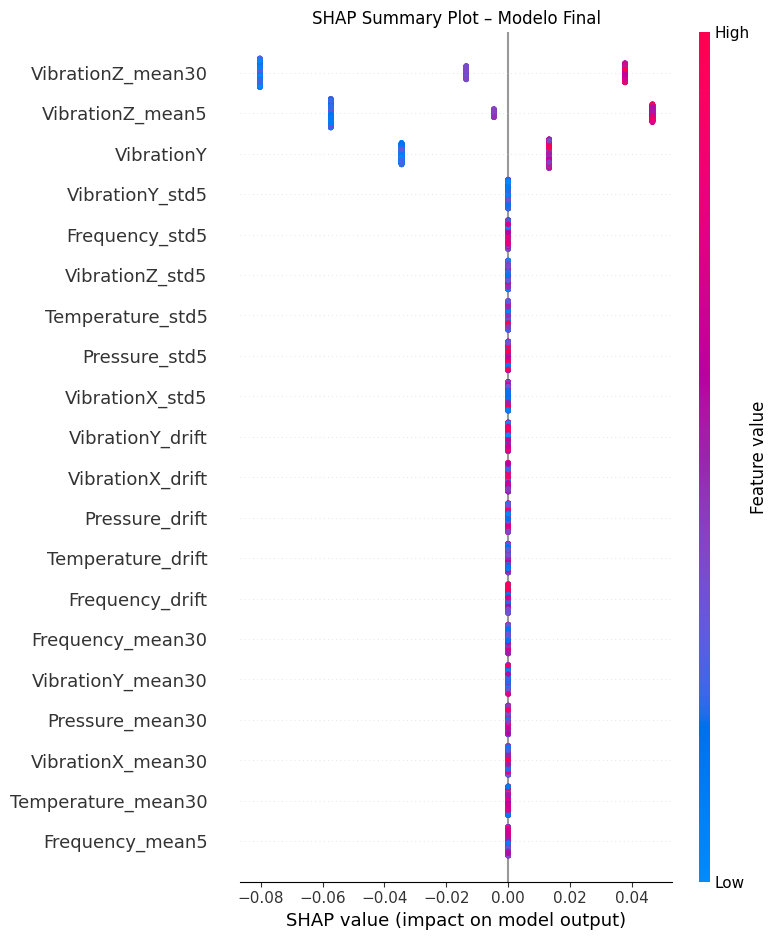

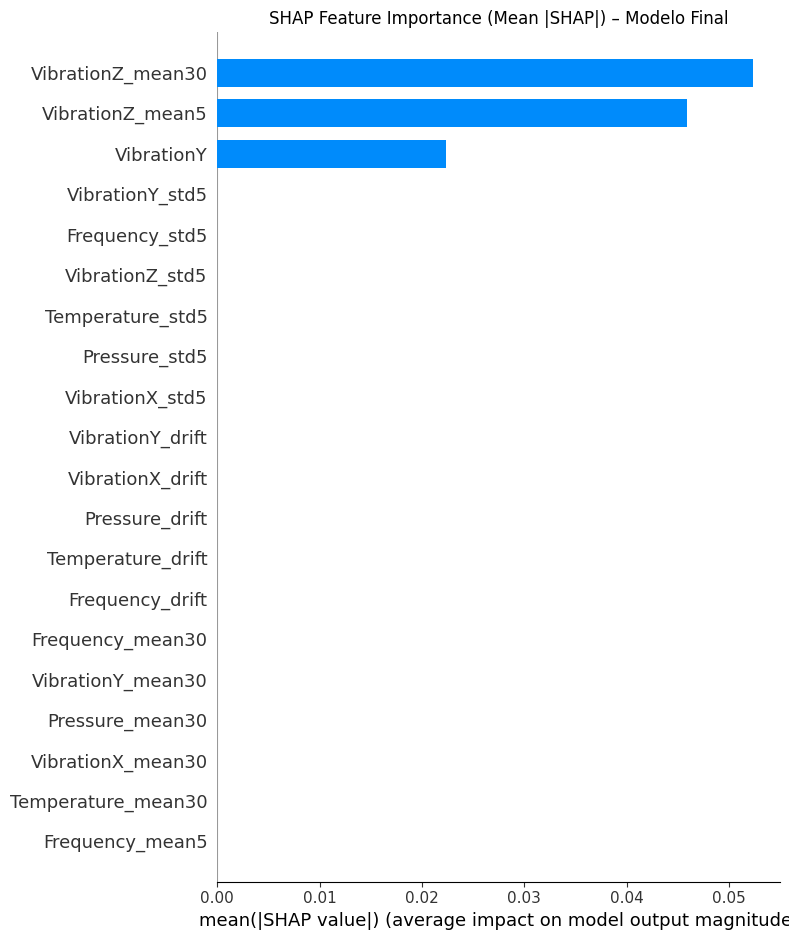

In [123]:
# SHAP - features importanc
##

# create an explainer from the tree model.
explainer = shap.TreeExplainer(xgb_model)

# calculate SHAP values ​​in the training set
shap_values = explainer.shap_values(X_train)

# ------------------------------------------------------------
# Summary plot (scatter plot) – shows the importance and direction of the effect.
# ------------------------------------------------------------
plt.figure()
shap.summary_plot(
    shap_values,
    X_train,
    show=False  # evita duplicar em alguns ambientes
)
plt.title("SHAP Summary Plot – Modelo Final")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Bar plot – average absolute importance (feature ranking)
# ------------------------------------------------------------
plt.figure()
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="bar",
    show=False
)
plt.title("SHAP Feature Importance (Mean |SHAP|) – Modelo Final")
plt.tight_layout()
plt.show()


To improve the model’s performance, I will rebuild the classifier using only the top 10 most important features. By restricting the model to the variables that contribute the most to predictive power, we reduce noise, simplify the decision boundary, and improve generalization. This feature selection step is expected to enhance both recall and overall stability of the failure prediction model

In [74]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)


In [75]:
# RANKING SHAP – select TOP 10 features

shap_abs = np.abs(shap_values).mean(axis=0)

shap_importance = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": shap_abs
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

top10_features = shap_importance["feature"].head(10).tolist()
print("TOP 10 FEATURES:", top10_features)


TOP 10 FEATURES: ['VibrationZ_mean30', 'VibrationZ_mean5', 'VibrationY_drift', 'VibrationX_mean30', 'VibrationY_mean30', 'Frequency_mean5', 'Pressure_mean30', 'VibrationX_mean5', 'VibrationY_mean5', 'VibrationX_std5']


In [76]:
X_train_top10 = X_train[top10_features]
X_test_top10  = X_test[top10_features]


In [78]:
# MODEL 4 - top 10

num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0

xgb_top10 = XGBClassifier(
    n_estimators=60,
    max_depth=2,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.5,
    min_child_weight=4,
    gamma=1.0,
    reg_lambda=4.0,        # L2 moderate
    reg_alpha=2.0,         # L1 moderate
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_top10.fit(X_train_top10, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=-1,
              num_parallel_tree=None, ...)

In [81]:
# Threshold tuning –

y_proba_top10_test = xgb_top10.predict_proba(X_test_top10)[:, 1]

th_res_top10 = eval_thresholds(y_test, y_proba_top10_test)

print("thr   precision  recall   f1")
for t, p, r, f1 in th_res_top10:
    print(f"{t:0.2f}  {p:0.3f}     {r:0.3f}   {f1:0.3f}")

best_thr_top10, best_p_top10, best_r_top10, best_f1_top10 = max(th_res_top10, key=lambda x: x[3])
print("\nBest threshold:", best_thr_top10)

y_pred_top10_test = (y_proba_top10_test >= best_thr_top10).astype(int)

print("\n=== TEST PERFORMANCE (TOP 10) ===")
print(classification_report(y_test, y_pred_top10_test, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_top10_test))

print("ROC-AUC:", roc_auc_score(y_test, y_proba_top10_test))
print("PR-AUC:", average_precision_score(y_test, y_proba_top10_test))


thr   precision  recall   f1
0.10  0.242     1.000   0.390
0.15  0.264     0.825   0.400
0.20  0.270     0.775   0.400
0.25  0.312     0.750   0.441
0.30  0.333     0.650   0.441
0.35  0.353     0.600   0.444
0.40  0.375     0.600   0.462
0.45  0.382     0.525   0.442
0.50  0.420     0.525   0.467
0.55  0.413     0.475   0.442
0.60  0.463     0.475   0.469
0.65  0.500     0.450   0.474
0.70  0.515     0.425   0.466
0.75  0.552     0.400   0.464
0.80  0.560     0.350   0.431
0.85  0.588     0.250   0.351
0.90  0.000     0.000   0.000

Best threshold: 0.65

=== TEST PERFORMANCE (TOP 10) ===
              precision    recall  f1-score   support

           0     0.8922    0.9100    0.9010       200
           1     0.5000    0.4500    0.4737        40

    accuracy                         0.8333       240
   macro avg     0.6961    0.6800    0.6873       240
weighted avg     0.8268    0.8333    0.8298       240

Confusion matrix:
[[182  18]
 [ 22  18]]
ROC-AUC: 0.7935625
PR-AUC: 0.4953102

In [82]:
# OVERFITTING TEST
##
y_proba_top10_train = xgb_top10.predict_proba(X_train_top10)[:, 1]
y_pred_top10_train  = (y_proba_top10_train >= best_thr_top10).astype(int)

roc_auc_train_10 = roc_auc_score(y_train, y_proba_top10_train)
roc_auc_test_10  = roc_auc_score(y_test,  y_proba_top10_test)

pr_auc_train_10  = average_precision_score(y_train, y_proba_top10_train)
pr_auc_test_10   = average_precision_score(y_test,  y_proba_top10_test)

f1_train_10 = f1_score(y_train, y_pred_top10_train)
f1_test_10  = f1_score(y_test,  y_pred_top10_test)

prec_train_10 = precision_score(y_train, y_pred_top10_train)
prec_test_10  = precision_score(y_test,  y_pred_top10_test)

rec_train_10 = recall_score(y_train, y_pred_top10_train)
rec_test_10  = recall_score(y_test,  y_pred_top10_test)

print("\n=== GENERALIZATION GAP (TOP 10 MODEL) ===")
print(f"ROC-AUC: train={roc_auc_train_10:.4f}  test={roc_auc_test_10:.4f}  diff={(roc_auc_train_10-roc_auc_test_10):.4f}")
print(f"PR-AUC : train={pr_auc_train_10:.4f}   test={pr_auc_test_10:.4f}   diff={(pr_auc_train_10-pr_auc_test_10):.4f}")
print(f"F1     : train={f1_train_10:.4f}       test={f1_test_10:.4f}       diff={(f1_train_10-f1_test_10):.4f}")
print(f"Prec   : train={prec_train_10:.4f}     test={prec_test_10:.4f}     diff={(prec_train_10-prec_test_10):.4f}")
print(f"Recall : train={rec_train_10:.4f}      test={rec_test_10:.4f}      diff={(rec_train_10-rec_test_10):.4f}")



=== GENERALIZATION GAP (TOP 10 MODEL) ===
ROC-AUC: train=0.9634  test=0.7936  diff=0.1698
PR-AUC : train=0.8268   test=0.4953   diff=0.3315
F1     : train=0.7733       test=0.4737       diff=0.2996
Prec   : train=0.6905     test=0.5000     diff=0.1905
Recall : train=0.8788      test=0.4500      diff=0.4288


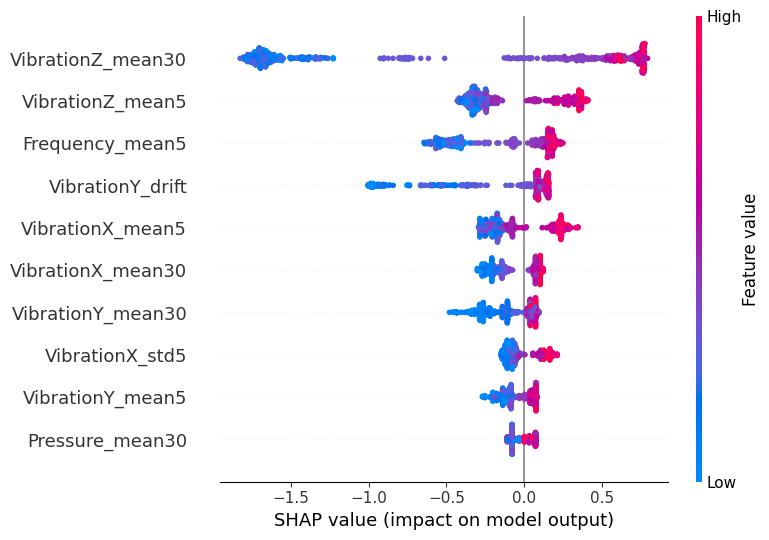

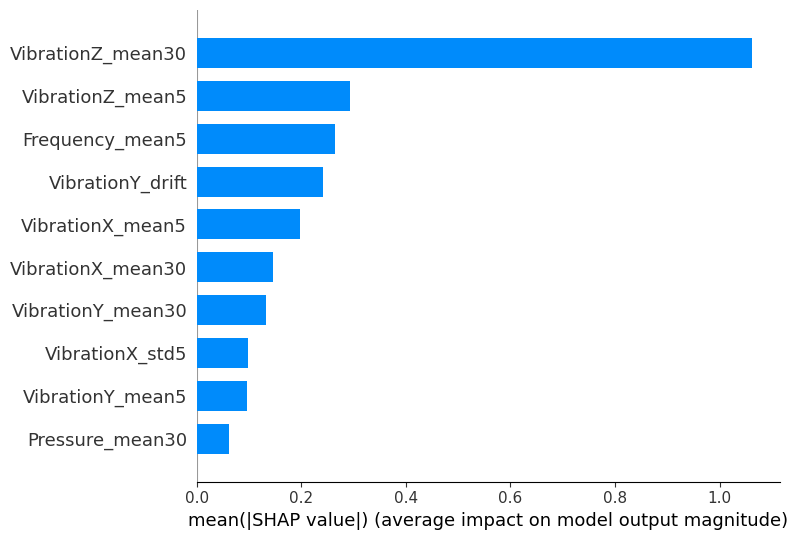

In [83]:
# SHAP – features importanc
##

explainer_top10 = shap.TreeExplainer(xgb_top10)
shap_values_top10 = explainer_top10.shap_values(X_train_top10)

# summary plot
shap.summary_plot(shap_values_top10, X_train_top10)

# bar plot
shap.summary_plot(shap_values_top10, X_train_top10, plot_type="bar")



The model trained with the top 10 most important features shows reasonable discrimination on the test set (ROC-AUC ≈ 0.79, PR-AUC ≈ 0.50), but its overall performance is still limited for reliable failure prediction. Precision and recall for the failure class remain modest (0.50 and 0.45), indicating that the model detects only part of the degradation patterns that precede failures.

The generalization gap reveals a more critical issue: the model performs substantially better on the training data than on unseen data. Large differences in PR-AUC (0.33), F1 (0.30), and recall (0.43) indicate that the classifier is overfitting even after feature reduction. This suggests that the top-10 feature set improves interpretability but is not sufficient to prevent the model from memorizing specific patterns rather than learning generalizable failure signatures.

In summary, although the simplified model reduces complexity, it still fails to generalize adequately and does not deliver the accuracy or robustness required for a dependable failure-forecasting system.